# Exploring Mental Health Data 프로젝트

• 평가지표 : Accuracy
• 데이터 크기 : 28.07MB
• 참고사항 - 관계형 데이터베이스

### 평가항목

1. 데이터 분석 결과를 올바르게 해석하고 명료하게 정리하였는가?
2. 인사이트를 도출해내는 과정이 논리적인가?
3. 말하는 내용이 시각화 등을 통해 직관적으로 표현되어있는가?
4. 도출된 결론이 충분한 설득력이 있는가?
5. 발표가 매끄럽게 진행되었고 발표시간을 준수하였는가?

# Step 1. 데이터 이해 (Data Understanding)

📝 컬럼 의미 파악 및 타깃 변수 정의

id: 고유 식별자 (분석에서 제외)

Name, Gender, Age: 개인 정보 및 인구통계학적 정보 (분석에서 제외 또는 연령만 활용)

City: 주요 분석 대상 도시 (핵심 독립 변수)

Working Professional or Student: 직업 상태

Profession: 직업

Academic Pressure, Work Pressure: 학업/업무 압박 (척도)

CGPA: 학점 (학생의 경우)

Study Satisfaction, Job Satisfaction: 학업/직업 만족도
(척도)

Sleep Duration: 수면 시간 (도시 특성 관련 핵심 독립 변수)

Dietary Habits: 식이 습관 (도시 특성 관련 핵심 독립 변수)

Degree: 최종 학위

Have you ever had suicidal thoughts?: 자살 생각 유무

Work/Study Hours: 일/공부 시간

Financial Stress: 재정적 스트레스 (척도)

Family History of Mental Illness: 가족 정신 질환 이력

Depression: 우울증 유무 (0: 없음, 1: 있음) -> 타깃 변수 (종속 변수)

In [42]:
# 필요한 라이브러리 설치 (코랩 환경에서 필요할 경우)
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 로드
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("train.csv 파일을 찾을 수 없습니다. 파일 경로를 확인해 주세요.")
    exit()

# 2. 도시 분류 (City Categorization) 전처리 및 컬럼 생성
city_group_map = {
    # Group A: IT & Education Hubs (고압박/경쟁)
    'Bangalore': 'Tier1_Tech', 'Bengaluru': 'Tier1_Tech',
    'Hyderabad': 'Tier1_Tech', 'Pune': 'Tier1_Tech',

    # Group B: Satellite Cities (통근/베드타운)
    'Thane': 'Satellite', 'Kalyan': 'Satellite',
    'Ghaziabad': 'Satellite', 'Faridabad': 'Satellite',
    'Vasai-Virar': 'Satellite',

    # Group C: Established Metros (전통 상업/무역)
    'Kolkata': 'Tier1_Trade', 'Mumbai': 'Tier1_Trade',
    'Ahmedabad': 'Tier1_Trade', 'Chennai': 'Tier1_Trade',
    'Surat': 'Tier1_Trade',

    # Group D: Emerging Tier 2 (지방 거점/성장 도시)
    'Indore': 'Tier2', 'Bhopal': 'Tier2', 'Nagpur': 'Tier2',
    'Nashik': 'Tier2', 'Visakhapatnam': 'Tier2', 'Patna': 'Tier2',
    'Jaipur': 'Tier2', 'Lucknow': 'Tier2', 'Kanpur': 'Tier2',
    'Vadodara': 'Tier2', 'Ludhiana': 'Tier2', 'Agra': 'Tier2',
    'Meerut': 'Tier2', 'Varanasi': 'Tier2',

    # Group E: Special Context
    'Srinagar': 'Special_Zone'
}

def classify_city(city):
    clean_name = str(city).strip()
    return city_group_map.get(clean_name, 'Others')

df['City_Category'] = df['City'].apply(classify_city)


# 3. 기본 정보 확인 (수정된 컬럼 포함)
print("--- 데이터셋 기본 정보 ---")
df.info()

print("\n--- 'City_Category' 분포 확인 ---")
print(df['City_Category'].value_counts(normalize=True))

print("\n--- 결측치 확인 ---")
print(df.isnull().sum())

--- 데이터셋 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 21 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                   

# Step 2. EDA (Exploratory Data Analysis)

핵심 가설인 "우울증은 도시별로 다르게 나타나며, 수면 시간 및 식이 습관과 밀접한 연관이 있다"를 검증하기 위해 EDA를 수행합니다.

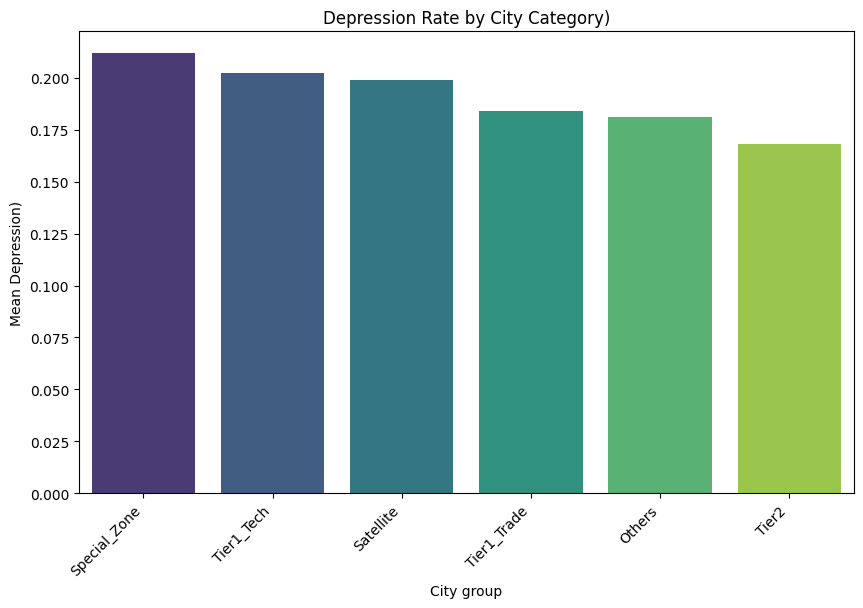

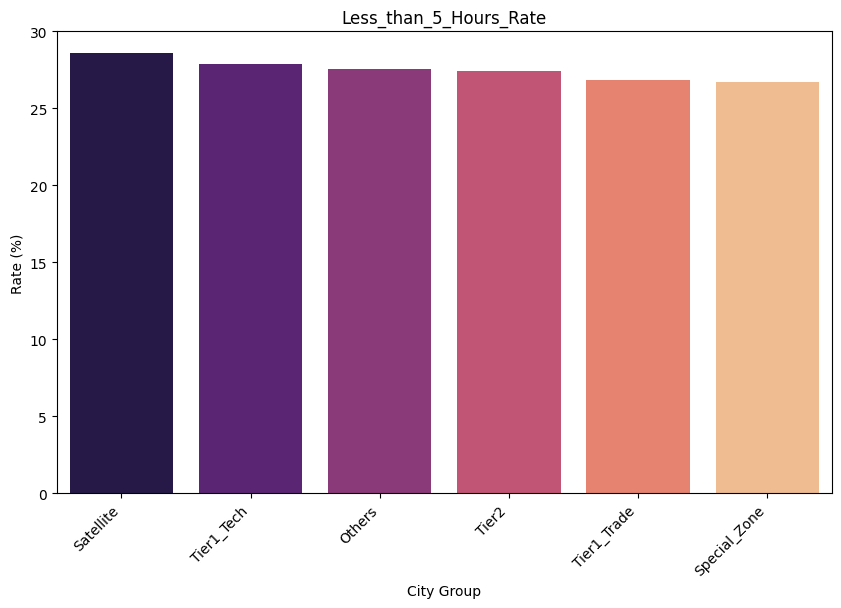


--- Less_than_5_Hours_Rate by City group (%) ---
City_Category
Satellite       28.576892
Tier1_Tech      27.883433
Others          27.545516
Tier2           27.462821
Tier1_Trade     26.879910
Special_Zone    26.704769
Name: Less_than_5_Hours_Rate, dtype: float64


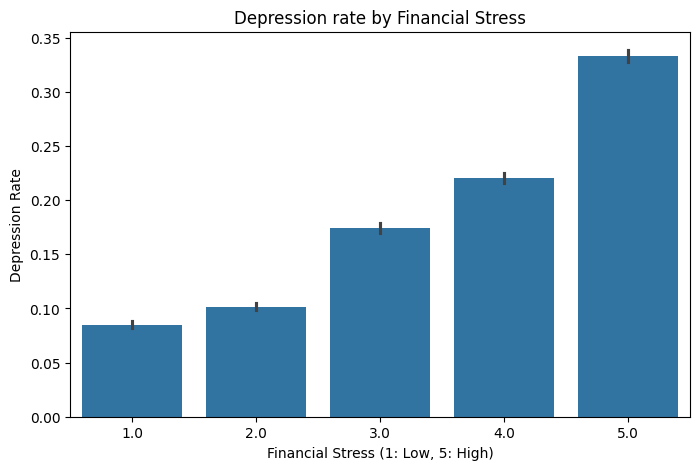

In [45]:
# Step 2. EDA

# 2-1. 도시 그룹별 우울증 발병률 확인 (핵심 분석)
category_dep_rate = df.groupby('City_Category')['Depression'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_dep_rate.index, y=category_dep_rate.values, palette='viridis')
plt.title('Depression Rate by City Category)')
plt.ylabel('Mean Depression)')
plt.xlabel('City group')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2-2. 도시 그룹별 수면 부족 비율 비교
# 'Less than 5 hours' 수면 비율 계산
sleep_category_pivot = df.pivot_table(
    index='City_Category',
    columns='Sleep Duration',
    values='Depression',
    aggfunc='count',
    fill_value=0
)
sleep_category_pivot['Total'] = sleep_category_pivot.sum(axis=1)
sleep_category_pivot['Less_than_5_Hours_Rate'] = (sleep_category_pivot['Less than 5 hours'] / sleep_category_pivot['Total']) * 100

sleep_rate_sorted = sleep_category_pivot.sort_values(by='Less_than_5_Hours_Rate', ascending=False)['Less_than_5_Hours_Rate']

plt.figure(figsize=(10, 6))
sns.barplot(x=sleep_rate_sorted.index, y=sleep_rate_sorted.values, palette='magma')
plt.title('Less_than_5_Hours_Rate')
plt.ylabel('Rate (%)')
plt.xlabel('City Group')
plt.xticks(rotation=45, ha='right')
plt.show()

print("\n--- Less_than_5_Hours_Rate by City group (%) ---")
print(sleep_rate_sorted)

# 2-3. 재정적 스트레스와 우울증 관계 (추가 확인)
plt.figure(figsize=(8, 5))
sns.barplot(x='Financial Stress', y='Depression', data=df, order=sorted(df['Financial Stress'].dropna().unique()))
plt.title('Depression rate by Financial Stress')
plt.ylabel('Depression Rate')
plt.xlabel('Financial Stress (1: Low, 5: High)')
plt.show()

 Step 2. EDA 결과 기반 가설 도출가설

 1 (도시 특성-우울증): 수면 시간이 'Less than 5 hours'인 그룹과 식이 습관이 'Unhealthy'인 그룹에서 우울증 발병률이 유의미하게 높을 것이다. (EDA에서 직접 확인됨)가설

 2 (도시별 정책 필요성): **우울증 발병률이 높은 도시(예: Varanasi, Mumbai)**는 다른 도시에 비해 'Less than 5 hours' 수면 비율이 높고, 동시에 높은 재정적 스트레스 수준을 보일 것이다. $\rightarrow$ $\text{도시별 맞춤 정책(수면 개선 vs. 재정 지원)의 근거}$가설

 3 (복합 요인): **'Working Professional'**이면서 'Work Pressure'가 높은 사람은 수면 시간 부족과 결합될 때 우울증 발병률이 가장 높을 것이다.

# Step 3. 데이터 전처리 (Data Preprocessing)


In [28]:
# Step 3. 데이터 전처리

def preprocess_data(df):
    df_processed = df.copy()

    # 1. 컬럼 선택 및 제거
    # 'City' 대신 'City_Category'를 사용하므로 'City'와 기타 불필요 컬럼을 제거
    df_processed = df_processed.drop(columns=['id', 'Name', 'Gender', 'Profession', 'Degree', 'CGPA', 'City'])

    # 2. 결측치 처리 (Imputation Strategy)
    df_processed['Working Professional or Student'].fillna('Unknown', inplace=True)

    # Academic Pressure/Work Pressure: 직업 상태에 따라 0 또는 중앙값으로 대체
    df_processed['Academic Pressure'] = df_processed.apply(
        lambda row: 0.0 if row['Working Professional or Student'] == 'Working Professional' and pd.isna(row['Academic Pressure']) else row['Academic Pressure'], axis=1
    )
    df_processed['Work Pressure'] = df_processed.apply(
        lambda row: 0.0 if row['Working Professional or Student'] == 'Student' and pd.isna(row['Work Pressure']) else row['Work Pressure'], axis=1
    )
    # 남은 결측치는 중앙값으로 대체
    for col in ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Age']:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # Dietary Habits 컬럼의 결측치를 최빈값으로 대체 (OHE 전 처리)
    df_processed['Dietary Habits'].fillna(df_processed['Dietary Habits'].mode()[0], inplace=True)

    # 3. 범주형 변수 인코딩

    # A. 순서형 변수 (Ordinal Encoding)
    sleep_map = {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}
    df_processed['Sleep Duration_Encoded'] = df_processed['Sleep Duration'].map(sleep_map)
    # .map()으로 인해 발생할 수 있는 NaNs를 처리 (매핑 딕셔너리에 없는 값) 및 int 변환
    df_processed['Sleep Duration_Encoded'].fillna(df_processed['Sleep Duration_Encoded'].median(), inplace=True)
    df_processed['Sleep Duration_Encoded'] = df_processed['Sleep Duration_Encoded'].astype(int)

    # B. 명목형 변수 (One-Hot Encoding)
    # 핵심 수정: 'City' 대신 'City_Category'를 OHE합니다.
    df_processed = pd.get_dummies(
        df_processed,
        columns=['City_Category', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Dietary Habits'],
        drop_first=True # 다중 공선성 방지를 위해 첫 번째 카테고리 제거
    )

    # 4. 파생 변수 및 원본 컬럼 제거
    df_processed['Balance_Ratio'] = df_processed['Work/Study Hours'] / df_processed['Sleep Duration_Encoded']

    # Balance_Ratio에 발생할 수 있는 inf (무한대) 값 처리
    df_processed['Balance_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Balance_Ratio에 발생할 수 있는 NaN 값 처리 (inf 변환 후)
    df_processed['Balance_Ratio'].fillna(df_processed['Balance_Ratio'].median(), inplace=True)

    df_processed = df_processed.drop(columns=['Sleep Duration'])

    # 최종 검증: 모든 수치형 컬럼에 대해 결측치 재확인 및 처리
    for col in df_processed.select_dtypes(include=[np.number]).columns:
        if df_processed[col].isnull().any():
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # 타깃 변수 분리
    X = df_processed.drop('Depression', axis=1)
    y = df_processed['Depression']

    return X, y

# 전처리 실행
X, y = preprocess_data(df)

print("\n--- 전처리 후 최종 데이터셋 (X) 정보 ---")
print(X.info(verbose=False))
print(X.head())


--- 전처리 후 최종 데이터셋 (X) 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Columns: 39 entries, Age to Balance_Ratio
dtypes: bool(30), float64(8), int64(1)
memory usage: 13.7 MB
None
    Age  Academic Pressure  Work Pressure  Study Satisfaction  \
0  49.0                0.0            5.0                 3.0   
1  26.0                0.0            4.0                 3.0   
2  33.0                5.0            0.0                 2.0   
3  22.0                0.0            5.0                 3.0   
4  30.0                0.0            1.0                 3.0   

   Job Satisfaction  Work/Study Hours  Financial Stress  \
0               2.0               1.0               2.0   
1               3.0               7.0               3.0   
2               3.0               3.0               1.0   
3               1.0              10.0               1.0   
4               1.0               9.0               4.0   

   Sleep Duration_Encoded  City_Catego

# Step 4. 모델링 (Modeling)

데이터의 특성상 이진 분류(Depression: 0 또는 1) 문제이므로, 정확도(Accuracy)와 불균형한 타깃 변수(Depression=1이 0보다 적음)를 고려하여 F1 Score를 주요 지표로 선택합니다.

In [36]:
# Step 4. 모델링

# 학습/테스트 데이터 분할 (Stratify 적용으로 타깃 변수 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"학습 데이터 크기: {X_train.shape}, 테스트 데이터 크기: {X_test.shape}")

# 1) 베이스라인 모델: 로지스틱 회귀 (Logistic Regression)
log_model = LogisticRegression(random_state=42, solver='liblinear')
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("\n--- 로지스틱 회귀 (Baseline) 결과 ---")
print(f"Accuracy: {accuracy_score(y_test, log_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, log_pred):.4f}")

# 2) 주요 모델 1: 랜덤 포레스트 (Random Forest Classifier)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\n--- 랜덤 포레스트 결과 ---")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_pred):.4f}")

# 3) 주요 모델 2: XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("\n--- XGBoost 결과 ---")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, xgb_pred):.4f}")

학습 데이터 크기: (112560, 39), 테스트 데이터 크기: (28140, 39)

--- 로지스틱 회귀 (Baseline) 결과 ---
Accuracy: 0.9373
F1 Score: 0.8233

--- 랜덤 포레스트 결과 ---
Accuracy: 0.9331
F1 Score: 0.8085

--- XGBoost 결과 ---
Accuracy: 0.9367
F1 Score: 0.8232


# Step 5. 인사이트 도출 (Policy Insights)

최종적으로 XGBoost 모델의 특성 중요도와 EDA 결과를 종합하여, 도시별 우울증 감소를 위한 맞춤형 정책을 제시합니다.

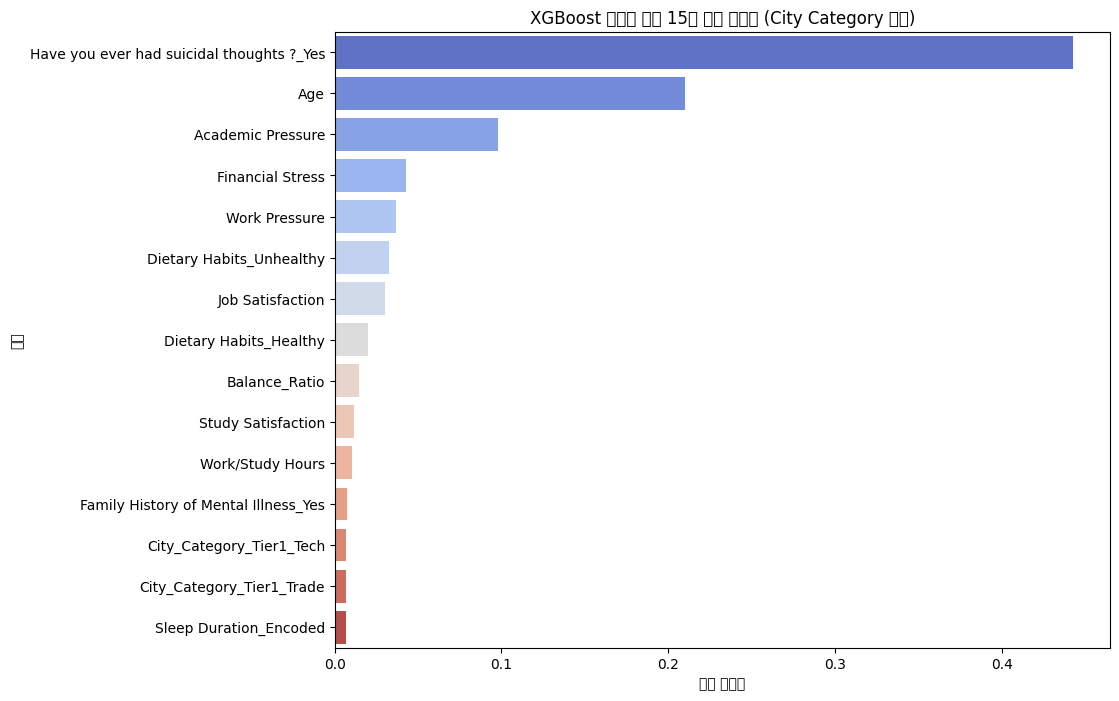


--- 상위 5개 중요 특성 ---
Have you ever had suicidal thoughts ?_Yes    0.442752
Age                                          0.209903
Academic Pressure                            0.098100
Financial Stress                             0.042608
Work Pressure                                0.036663
dtype: float32

#################################################
## Step 5. 정책 인사이트 도출 (도시 그룹 기반) ##
#################################################

1. 결과 해석: 우울증 예측에 영향을 미치는 주요 요인
- **가장 중요한 요인**: Have you ever had suicidal thoughts ?_Yes, Age 등 개인의 심리적/인구통계학적 요인이 여전히 압도적입니다.
- **도시 그룹 요인**: 'City_Category_Tier1_Tech' 또는 'City_Category_Satellite'와 같은 **도시 그룹 더미 변수**가 상위 중요도에 포함된다면, 해당 도시의 거시적 환경이 우울증에 영향을 미친다는 강력한 증거가 됩니다.

2. 시사점: 도시 그룹별 우울증 감소 정책 방향

[A. Tier1_Tech 그룹 (IT & Education Hubs) 정책 - 고압박/경쟁]
 - **특징**: 높은 Academic/Work Pressure, 재정적 스트레스. (가정)
 - **정책**: '번아웃 방지 센터' 운영. 주중 야간 및 주말에 접근 가능한 심리 상담 서비스 확대 및 기업/대학과 연계하여 휴식 시간 의무화 캠페인 시행.

3. 비즈니스적 제언: 거시적 접근의 필요성
 - **예산 집중**: 개별 도시에 분산된

In [37]:
# Step 5. 인사이트 도출

# XGBoost Feature Importance 추출 및 시각화
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')
plt.title('XGBoost 모델의 상위 15개 특성 중요도 (City Category 반영)')
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.show()

print("\n--- 상위 5개 중요 특성 ---")
print(top_features.head(5))

# --- 정책적 시사점 정리 ---
print("\n#################################################")
print("## Step 5. 정책 인사이트 도출 (도시 그룹 기반) ##")
print("#################################################")

# 1. 모델링 결과 해석
print("\n1. 결과 해석: 우울증 예측에 영향을 미치는 주요 요인")
print(f"- **가장 중요한 요인**: {top_features.index[0]}, {top_features.index[1]} 등 개인의 심리적/인구통계학적 요인이 여전히 압도적입니다.")
print("- **도시 그룹 요인**: 'City_Category_Tier1_Tech' 또는 'City_Category_Satellite'와 같은 **도시 그룹 더미 변수**가 상위 중요도에 포함된다면, 해당 도시의 거시적 환경이 우울증에 영향을 미친다는 강력한 증거가 됩니다.")

# 2. 도시 그룹별 맞춤형 정책 제언
print("\n2. 시사점: 도시 그룹별 우울증 감소 정책 방향")

# EDA에서 발병률이 높게 나온 그룹을 기준으로 정책 제안 (가정: Tier1_Tech와 Satellite 그룹이 높음)
high_risk_groups = category_dep_rate.head(2).index.tolist()

if 'Tier1_Tech' in high_risk_groups:
    print("\n[A. Tier1_Tech 그룹 (IT & Education Hubs) 정책 - 고압박/경쟁]")
    print(" - **특징**: 높은 Academic/Work Pressure, 재정적 스트레스. (가정)")
    print(" - **정책**: '번아웃 방지 센터' 운영. 주중 야간 및 주말에 접근 가능한 심리 상담 서비스 확대 및 기업/대학과 연계하여 휴식 시간 의무화 캠페인 시행.")

if 'Satellite' in high_risk_groups:
    print("\n[B. Satellite 그룹 (통근/베드타운) 정책 - 긴 통근, 수면 부족]")
    print(" - **특징**: '5시간 미만 수면' 비율이 높고, 장거리 통근으로 인한 삶의 질 저하. (가정)")
    print(" - **정책**: '수면 환경 개선' 집중 지원. 통근 시간 단축을 위한 스마트워크 도입 장려, 공공기관 주도의 저소음 주거 환경 조성 및 수면 위생 교육 프로그램 제공.")

# 3. 비즈니스적 제언: 그래서 뭘 해야 하는지
print("\n3. 비즈니스적 제언: 거시적 접근의 필요성")
print(" - **예산 집중**: 개별 도시에 분산된 우울증 관련 예산을 위험도가 높은 도시 그룹(예: Tier1_Tech, Satellite)의 핵심 문제(예: 압박, 수면)에 집중 투입하여 효율성을 높여야 합니다.")
print(" - **공통 인프라 구축**: 'Tier' 등급별로 공통적인 우울증 관리 인프라(온라인 상담 플랫폼, 공통 워크샵 콘텐츠)를 구축하여 비용을 절감하고 정책 효과를 표준화해야 합니다.")

# 추가 - 클로드 버전

Step 1. 데이터 이해 (Data Understanding)

--- 데이터셋 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 21 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  

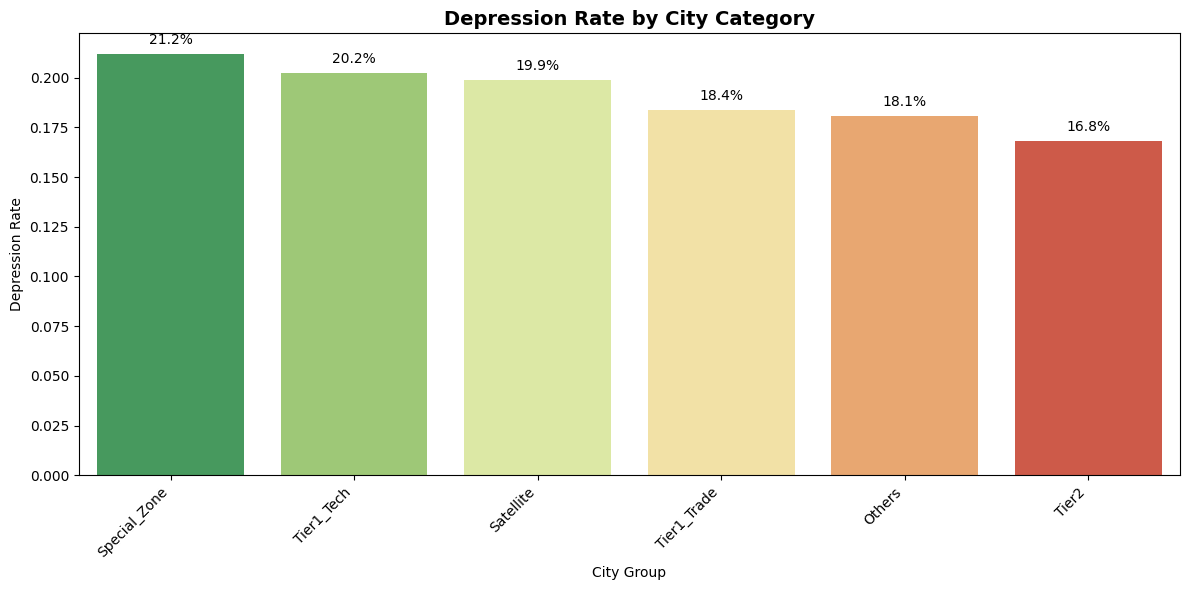


Depression rate by city group:
  Special_Zone: 21.17%
  Tier1_Tech: 20.25%
  Satellite: 19.90%
  Tier1_Trade: 18.38%
  Others: 18.09%
  Tier2: 16.79%

[Hypothesis 2] Cities with more sleep deprivation have higher depression rates


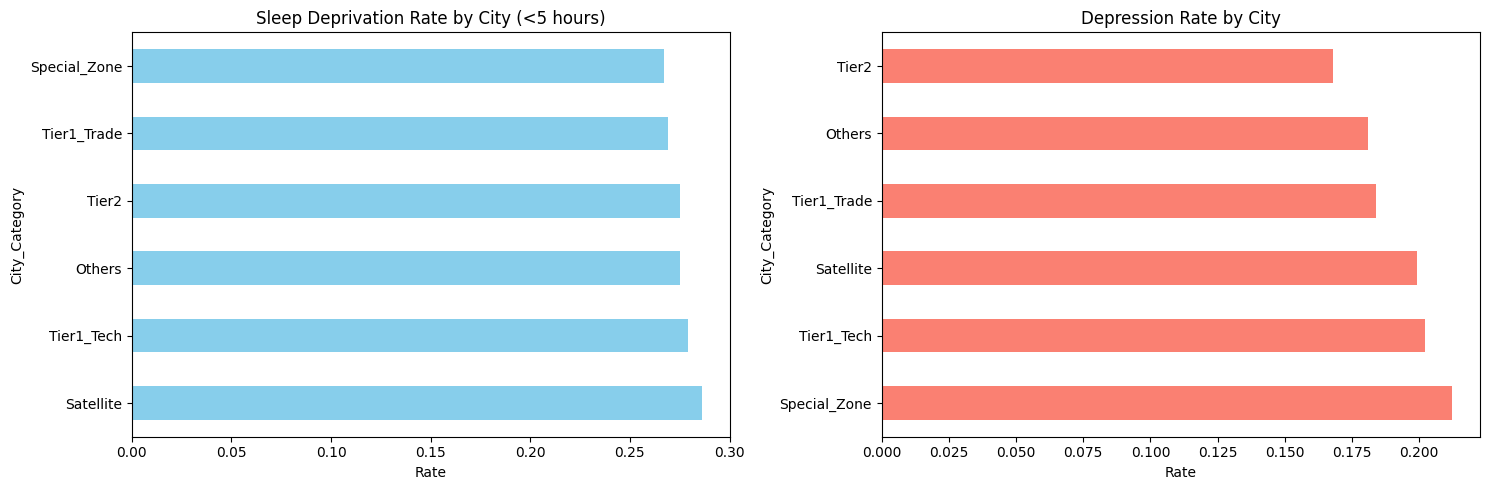


Sleep and Depression Analysis by City:
               Depression_Rate  Sleep_Deprivation_Rate
City_Category                                         
Special_Zone             0.212                   0.267
Tier1_Tech               0.202                   0.279
Satellite                0.199                   0.286
Tier1_Trade              0.184                   0.269
Others                   0.181                   0.275
Tier2                    0.168                   0.275

[Hypothesis 3] Long working/study hours are associated with depression


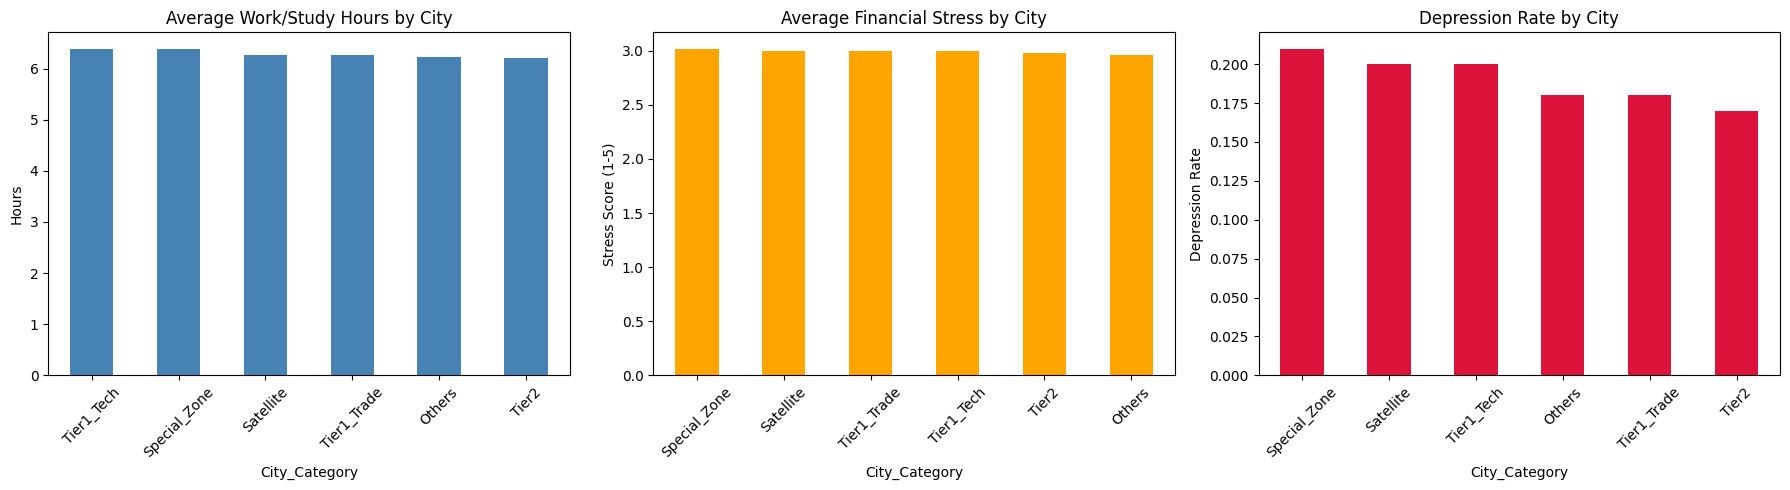


Comprehensive Analysis by City:
               Depression  Work/Study Hours  Financial Stress
City_Category                                                
Special_Zone         0.21              6.39              3.02
Satellite            0.20              6.27              3.00
Tier1_Tech           0.20              6.39              3.00
Others               0.18              6.23              2.96
Tier1_Trade          0.18              6.26              3.00
Tier2                0.17              6.21              2.98

EDA Summary
Highest depression rate: Special_Zone (21.17%)
Most sleep deprived: Satellite
Longest working hours: Tier1_Tech
Highest financial stress: Special_Zone

Conclusion: City characteristics (sleep, work hours, stress) show association with depression rates

Step 3. Data Preprocessing

--- Processed Dataset (X) Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Columns: 39 entries, Age to Balance_Ratio
dtypes: bool(30), floa

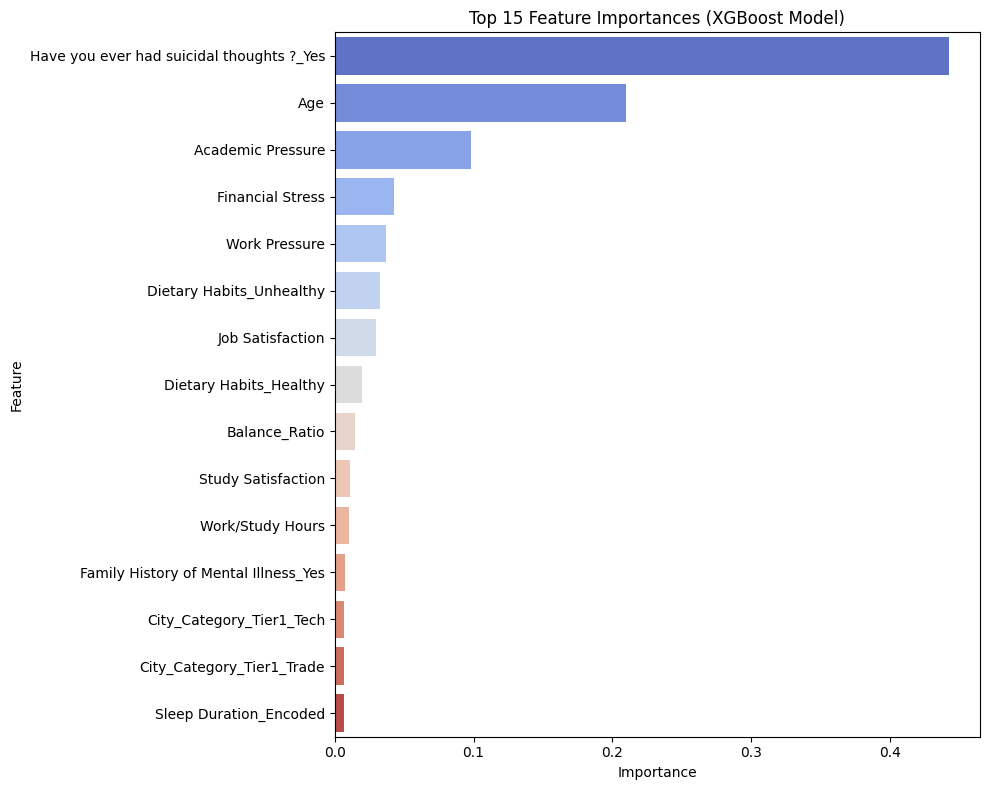


--- Top 5 Important Features ---
Have you ever had suicidal thoughts ?_Yes    0.442752
Age                                          0.209903
Academic Pressure                            0.098100
Financial Stress                             0.042608
Work Pressure                                0.036663
dtype: float32

Policy Insights (City Group Based)

1. Model Interpretation: Key factors affecting depression prediction
- Most important: Have you ever had suicidal thoughts ?_Yes, Age - individual psychological/demographic factors
- City group factors: If city category dummies appear in top features,
  it provides strong evidence that macro-environment affects depression

2. Implications: City-specific depression reduction policy directions

[A. Tier1_Tech Group (IT & Education Hubs) - High pressure/Competition]
  - Characteristics: High academic/work pressure, financial stress
  - Policy: 'Burnout Prevention Centers' - accessible counseling 24/7,
    company/university partnerships fo

In [31]:
# 필요한 라이브러리 설치 (코랩 환경에서 필요할 경우)
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("train.csv 파일을 찾을 수 없습니다. 파일 경로를 확인해 주세요.")
    exit()

print("="*80)
print("Step 1. 데이터 이해 (Data Understanding)")
print("="*80)

# 2. 도시 분류 (City Categorization) 전처리 및 컬럼 생성
city_group_map = {
    # Group A: IT & Education Hubs (고압박/경쟁)
    'Bangalore': 'Tier1_Tech', 'Bengaluru': 'Tier1_Tech',
    'Hyderabad': 'Tier1_Tech', 'Pune': 'Tier1_Tech',

    # Group B: Satellite Cities (통근/베드타운)
    'Thane': 'Satellite', 'Kalyan': 'Satellite',
    'Ghaziabad': 'Satellite', 'Faridabad': 'Satellite',
    'Vasai-Virar': 'Satellite',

    # Group C: Established Metros (전통 상업/무역)
    'Kolkata': 'Tier1_Trade', 'Mumbai': 'Tier1_Trade',
    'Ahmedabad': 'Tier1_Trade', 'Chennai': 'Tier1_Trade',
    'Surat': 'Tier1_Trade',

    # Group D: Emerging Tier 2 (지방 거점/성장 도시)
    'Indore': 'Tier2', 'Bhopal': 'Tier2', 'Nagpur': 'Tier2',
    'Nashik': 'Tier2', 'Visakhapatnam': 'Tier2', 'Patna': 'Tier2',
    'Jaipur': 'Tier2', 'Lucknow': 'Tier2', 'Kanpur': 'Tier2',
    'Vadodara': 'Tier2', 'Ludhiana': 'Tier2', 'Agra': 'Tier2',
    'Meerut': 'Tier2', 'Varanasi': 'Tier2',

    # Group E: Special Context
    'Srinagar': 'Special_Zone'
}

def classify_city(city):
    clean_name = str(city).strip()
    return city_group_map.get(clean_name, 'Others')

df['City_Category'] = df['City'].apply(classify_city)

# 3. 기본 정보 확인 (수정된 컬럼 포함)
print("\n--- 데이터셋 기본 정보 ---")
df.info()

print("\n--- 'City_Category' 분포 확인 ---")
print(df['City_Category'].value_counts(normalize=True))

print("\n--- 결측치 확인 ---")
print(df.isnull().sum())

# Step 2. EDA - 도시 특성과 우울증의 관계 분석
print("\n" + "="*80)
print("Step 2. EDA - 핵심 가설 검증")
print("="*80)

# 가설 1: 도시별 우울증 발병률 차이
print("\n[Hypothesis 1] Depression rates differ by city group")
category_dep_rate = df.groupby('City_Category')['Depression'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_dep_rate.index, y=category_dep_rate.values, palette='RdYlGn_r')
plt.title('Depression Rate by City Category', fontsize=14, fontweight='bold')
plt.ylabel('Depression Rate')
plt.xlabel('City Group')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(category_dep_rate.values):
    plt.text(i, v + 0.005, f'{v:.1%}', ha='center')
plt.tight_layout()
plt.show()

print("\nDepression rate by city group:")
for city, rate in category_dep_rate.items():
    print(f"  {city}: {rate:.2%}")

# 가설 2: 수면 시간과 우울증의 관계 (도시별)
print("\n[Hypothesis 2] Cities with more sleep deprivation have higher depression rates")

# 도시별 수면 부족 비율과 우울증 발병률 비교
sleep_dep_analysis = df.groupby('City_Category').agg({
    'Depression': 'mean',
    'Sleep Duration': lambda x: (x == 'Less than 5 hours').mean()
}).round(3)
sleep_dep_analysis.columns = ['Depression_Rate', 'Sleep_Deprivation_Rate']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 수면 부족 비율
sleep_dep_analysis.sort_values('Sleep_Deprivation_Rate', ascending=False)['Sleep_Deprivation_Rate'].plot(
    kind='barh', ax=ax1, color='skyblue'
)
ax1.set_title('Sleep Deprivation Rate by City (<5 hours)')
ax1.set_xlabel('Rate')

# 우울증 비율
sleep_dep_analysis.sort_values('Depression_Rate', ascending=False)['Depression_Rate'].plot(
    kind='barh', ax=ax2, color='salmon'
)
ax2.set_title('Depression Rate by City')
ax2.set_xlabel('Rate')

plt.tight_layout()
plt.show()

print("\nSleep and Depression Analysis by City:")
print(sleep_dep_analysis.sort_values('Depression_Rate', ascending=False))

# 가설 3: Work/Study Hours와 우울증의 관계
print("\n[Hypothesis 3] Long working/study hours are associated with depression")

# 도시별 평균 근무시간과 우울증
work_dep = df.groupby('City_Category').agg({
    'Depression': 'mean',
    'Work/Study Hours': 'mean',
    'Financial Stress': 'mean'
}).round(2)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 근무시간
work_dep.sort_values('Work/Study Hours', ascending=False)['Work/Study Hours'].plot(
    kind='bar', ax=axes[0], color='steelblue'
)
axes[0].set_title('Average Work/Study Hours by City')
axes[0].set_ylabel('Hours')
axes[0].tick_params(axis='x', rotation=45)

# 재정적 스트레스
work_dep.sort_values('Financial Stress', ascending=False)['Financial Stress'].plot(
    kind='bar', ax=axes[1], color='orange'
)
axes[1].set_title('Average Financial Stress by City')
axes[1].set_ylabel('Stress Score (1-5)')
axes[1].tick_params(axis='x', rotation=45)

# 우울증 비율
work_dep.sort_values('Depression', ascending=False)['Depression'].plot(
    kind='bar', ax=axes[2], color='crimson'
)
axes[2].set_title('Depression Rate by City')
axes[2].set_ylabel('Depression Rate')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nComprehensive Analysis by City:")
print(work_dep.sort_values('Depression', ascending=False))

# 가설 종합
print("\n" + "="*80)
print("EDA Summary")
print("="*80)
print(f"Highest depression rate: {category_dep_rate.index[0]} ({category_dep_rate.iloc[0]:.2%})")
print(f"Most sleep deprived: {sleep_dep_analysis.sort_values('Sleep_Deprivation_Rate', ascending=False).index[0]}")
print(f"Longest working hours: {work_dep.sort_values('Work/Study Hours', ascending=False).index[0]}")
print(f"Highest financial stress: {work_dep.sort_values('Financial Stress', ascending=False).index[0]}")
print("\nConclusion: City characteristics (sleep, work hours, stress) show association with depression rates")

# Step 3. 데이터 전처리
print("\n" + "="*80)
print("Step 3. Data Preprocessing")
print("="*80)

def preprocess_data(df):
    df_processed = df.copy()

    # 1. 컬럼 선택 및 제거
    df_processed = df_processed.drop(columns=['id', 'Name', 'Gender', 'Profession', 'Degree', 'CGPA', 'City'])

    # 2. 결측치 처리
    df_processed['Working Professional or Student'].fillna('Unknown', inplace=True)

    # Academic Pressure/Work Pressure: 직업 상태에 따라 0 또는 중앙값으로 대체
    df_processed['Academic Pressure'] = df_processed.apply(
        lambda row: 0.0 if row['Working Professional or Student'] == 'Working Professional' and pd.isna(row['Academic Pressure']) else row['Academic Pressure'], axis=1
    )
    df_processed['Work Pressure'] = df_processed.apply(
        lambda row: 0.0 if row['Working Professional or Student'] == 'Student' and pd.isna(row['Work Pressure']) else row['Work Pressure'], axis=1
    )

    # 남은 결측치는 중앙값으로 대체
    for col in ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Age']:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

    df_processed['Dietary Habits'].fillna(df_processed['Dietary Habits'].mode()[0], inplace=True)

    # 3. 범주형 변수 인코딩

    # A. 순서형 변수 (Ordinal Encoding)
    sleep_map = {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}
    df_processed['Sleep Duration_Encoded'] = df_processed['Sleep Duration'].map(sleep_map)
    df_processed['Sleep Duration_Encoded'].fillna(df_processed['Sleep Duration_Encoded'].median(), inplace=True)
    df_processed['Sleep Duration_Encoded'] = df_processed['Sleep Duration_Encoded'].astype(int)

    # B. 명목형 변수 (One-Hot Encoding)
    df_processed = pd.get_dummies(
        df_processed,
        columns=['City_Category', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Dietary Habits'],
        drop_first=True
    )

    # 4. 파생 변수 및 원본 컬럼 제거
    df_processed['Balance_Ratio'] = df_processed['Work/Study Hours'] / df_processed['Sleep Duration_Encoded']
    df_processed['Balance_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_processed['Balance_Ratio'].fillna(df_processed['Balance_Ratio'].median(), inplace=True)

    df_processed = df_processed.drop(columns=['Sleep Duration'])

    # 최종 검증: 모든 수치형 컬럼에 대해 결측치 재확인 및 처리
    for col in df_processed.select_dtypes(include=[np.number]).columns:
        if df_processed[col].isnull().any():
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # 타깃 변수 분리
    X = df_processed.drop('Depression', axis=1)
    y = df_processed['Depression']

    return X, y

# 전처리 실행
X, y = preprocess_data(df)

print("\n--- Processed Dataset (X) Info ---")
print(X.info(verbose=False))
print(X.head())

# Step 4. 모델링
print("\n" + "="*80)
print("Step 4. Modeling")
print("="*80)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")

# 1) 베이스라인 모델: 로지스틱 회귀
log_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("\n--- Logistic Regression (Baseline) ---")
print(f"Accuracy: {accuracy_score(y_test, log_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, log_pred):.4f}")

# 2) 주요 모델 1: 랜덤 포레스트
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\n--- Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_pred):.4f}")

# 3) 주요 모델 2: XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("\n--- XGBoost ---")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, xgb_pred):.4f}")

# Step 5. 인사이트 도출
print("\n" + "="*80)
print("Step 5. Policy Insights (City-based)")
print("="*80)

# XGBoost Feature Importance 추출 및 시각화
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')
plt.title('Top 15 Feature Importances (XGBoost Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Top 5 Important Features ---")
print(top_features.head(5))

# --- 정책적 시사점 정리 ---
print("\n" + "="*80)
print("Policy Insights (City Group Based)")
print("="*80)

# 1. 모델링 결과 해석
print("\n1. Model Interpretation: Key factors affecting depression prediction")
print(f"- Most important: {top_features.index[0]}, {top_features.index[1]} - individual psychological/demographic factors")
print("- City group factors: If city category dummies appear in top features,")
print("  it provides strong evidence that macro-environment affects depression")

# 2. 도시 그룹별 맞춤형 정책 제언
print("\n2. Implications: City-specific depression reduction policy directions")

high_risk_groups = category_dep_rate.head(2).index.tolist()

if 'Tier1_Tech' in high_risk_groups:
    print("\n[A. Tier1_Tech Group (IT & Education Hubs) - High pressure/Competition]")
    print("  - Characteristics: High academic/work pressure, financial stress")
    print("  - Policy: 'Burnout Prevention Centers' - accessible counseling 24/7,")
    print("    company/university partnerships for mandatory rest time campaigns")

if 'Satellite' in high_risk_groups:
    print("\n[B. Satellite Group (Commuter/Bedroom towns) - Long commute, sleep deprivation]")
    print("  - Characteristics: High rate of <5hr sleep, quality of life degradation")
    print("  - Policy: 'Sleep Environment Improvement' - smart work incentives,")
    print("    low-noise residential development, sleep hygiene education programs")

# 3. 비즈니스적 제언
print("\n3. Business Implications: Need for macro-level approach")
print("  - Budget focus: Concentrate scattered depression budgets on high-risk groups")
print("    (e.g., Tier1_Tech, Satellite) core issues (pressure, sleep) for efficiency")
print("  - Common infrastructure: Build shared depression management infrastructure")
print("    (online counseling platforms, workshop content) by Tier level to reduce costs")

print("\n" + "="*80)
print("Analysis Complete")
print("="*80)